# Kỹ thuật tăng cường tương phản ảnh
Trong phần này cần thực hiện
- Cân bằng histogram (histogram equalization)
- Cân bằng động histogram (dynamic histogram equalization)
- Một thuật toán mới tăng cường tương phản ảnh sử dụng framework Exposure Fusio

# Ảnh thực hành

In [1]:
import cv2
import matplotlib.pyplot as plt
import os

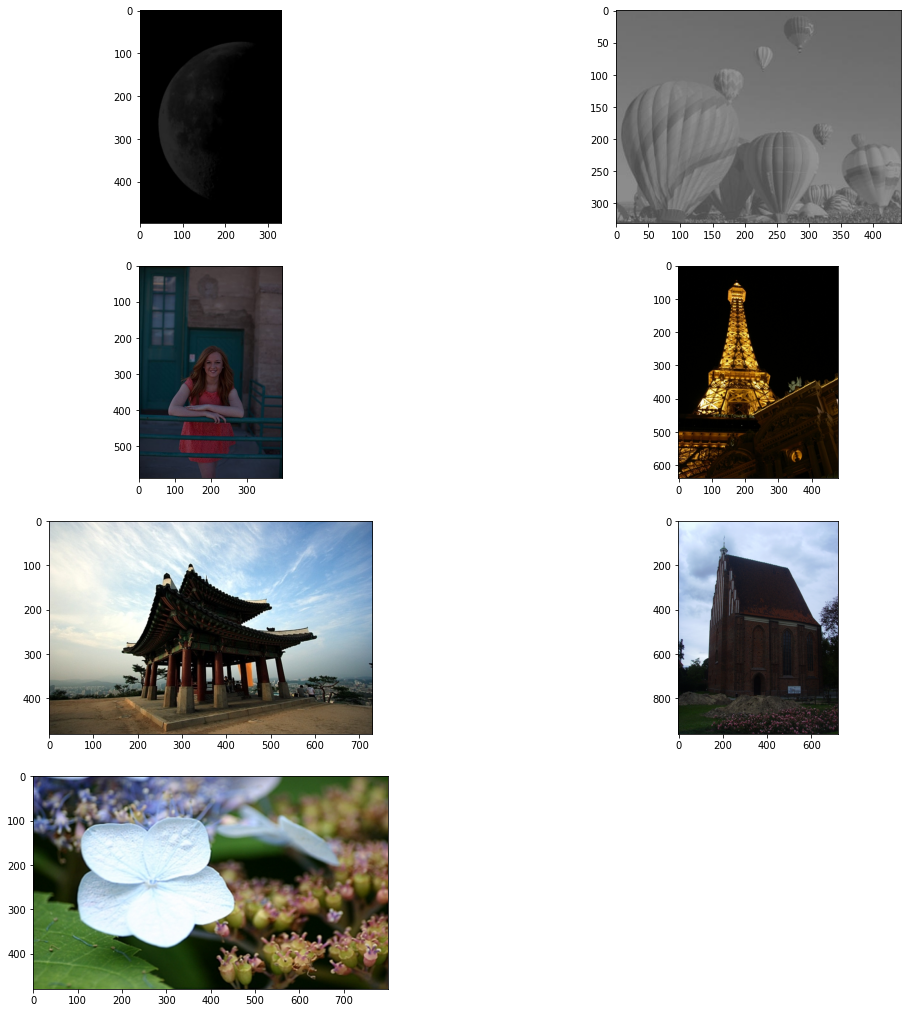

In [18]:
img_names = os.listdir('testdata/')
plt.figure(figsize=(18, 18)) 
for i, img_name in enumerate(img_names):
    img = cv2.imread(os.path.join('testdata/', img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # for showing purpose
    plt.subplot(4,2,i+1)
    plt.imshow(img) 
plt.show()

# Cân bằng Histogram

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Yêu cầu
Hoàn thiện hàm he với trường hợp ảnh đầu vào là ảnh màu

In [18]:
def he(img):
    # if input image is gray image
    if(len(img.shape)==2):
        outImg = cv2.equalizeHist(img)
    
    # if input image is color image
    ### YOUR CODE HERE ###
    else:
        img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
        img_hls[:, :, 1] = clahe.apply(img_hls[:, :, 1])
        # img_hls[:, :, 1] = cv2.equalizeHist(img_hls[:, :, 1])
        outImg = cv2.cvtColor(img_hls, cv2.COLOR_HLS2BGR)


    ### YOUR CODE HERE ###

    return outImg

# Yêu cầu
- Lấy danh sách tên ảnh trong folder testdata
- Loop qua từng ảnh, đọc ảnh và truyền vào hàm he
- Hiển thị ảnh kết quả

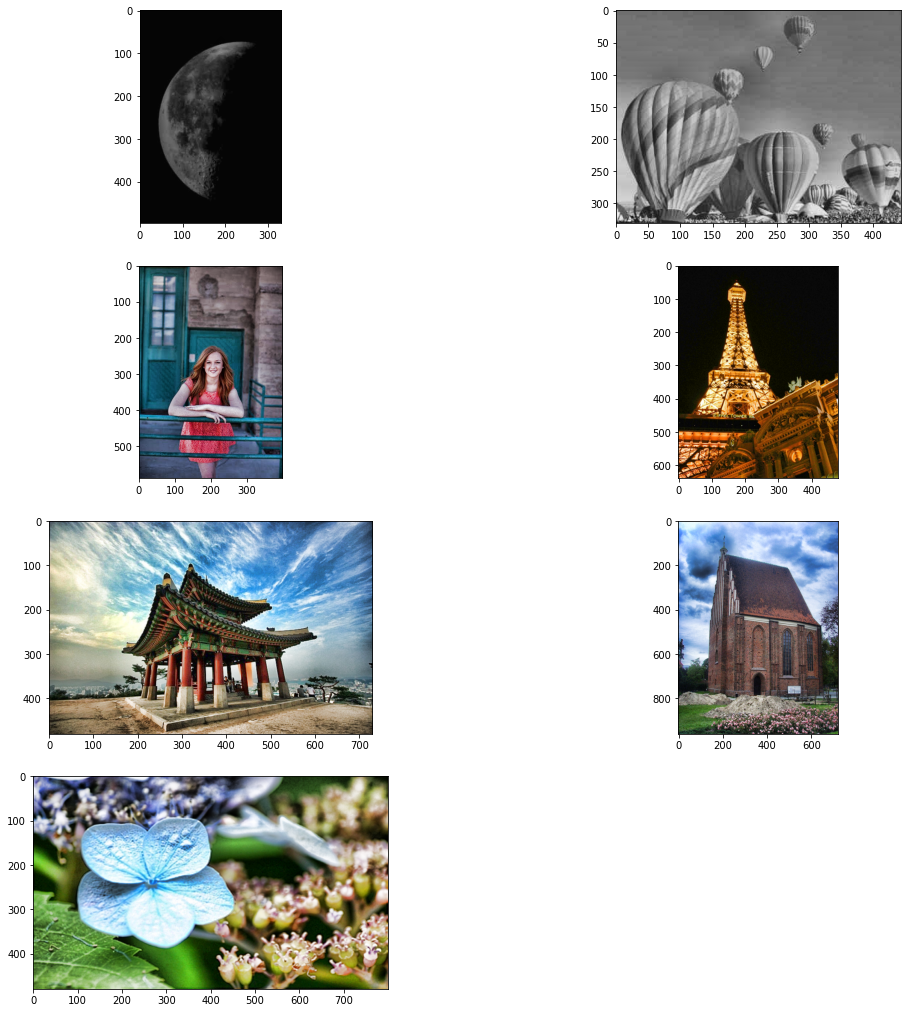

In [19]:
### YOUR CODE HERE ###
img_names = os.listdir('testdata/')
plt.figure(figsize=(18, 18))
for i, img_name in enumerate(img_names):
    img = cv2.imread(os.path.join('testdata/', img_name))
    img = he(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # for showing purpose
    plt.subplot(4,2,i+1)
    plt.imshow(img)
plt.show()

# Cân bằng mức xám động

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import imageio
import scipy, scipy.misc, scipy.signal
import cv2
import sys

# Yêu cầu
Hoàn thiện hàm build_is_hist và dhe

Tài liệu tham khảo: https://www.researchgate.net/publication/3183129_A_Dynamic_Histogram_Equalization_for_Image_Contrast_Enhancement

In [24]:
def build_is_hist(img):
    hei = img.shape[0]
    wid = img.shape[1]
    ch = img.shape[2]
    Img = np.zeros((hei+4, wid+4, ch))
    for i in range(ch):
        Img[:,:,i] = np.pad(img[:,:,i], (2,2), 'edge')
    hsv = (matplotlib.colors.rgb_to_hsv(Img))
    hsv[:,:,0] = hsv[:,:,0] * 255
    hsv[:,:,1] = hsv[:,:,1] * 255
    hsv[hsv>255] = 255
    hsv[hsv<0] = 0
    hsv = hsv.astype(np.uint8).astype(np.float64)
    fh = np.array([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
    fv = fh.conj().T

    H = hsv[:,:,0]
    S = hsv[:,:,1]
    I = hsv[:,:,2]

    dIh = scipy.signal.convolve2d(I, np.rot90(fh, 2), mode='same')
    dIv = scipy.signal.convolve2d(I, np.rot90(fv, 2), mode='same')
    dIh[dIh==0] = 0.00001
    dIv[dIv==0] = 0.00001
    dI = np.sqrt(dIh**2+dIv**2).astype(np.uint32)
    di = dI[2:hei+2,2:wid+2]

    dSh = scipy.signal.convolve2d(S, np.rot90(fh, 2), mode='same')
    dSv = scipy.signal.convolve2d(S, np.rot90(fv, 2), mode='same')
    dSh[dSh==0] = 0.00001
    dSv[dSv==0] = 0.00001
    dS = np.sqrt(dSh**2+dSv**2).astype(np.uint32)
    ds = dS[2:hei+2,2:wid+2]


    h = H[2:hei+2,2:wid+2]
    s = S[2:hei+2,2:wid+2]
    i = I[2:hei+2,2:wid+2].astype(np.uint8)

    Imean = scipy.signal.convolve2d(I,np.ones((5,5))/25, mode='same')
    Smean = scipy.signal.convolve2d(S,np.ones((5,5))/25, mode='same')

    Rho = np.zeros((hei+4,wid+4))
    for p in range(2,hei+2):
        for q in range(2,wid+2):
            tmpi = I[p-2:p+3,q-2:q+3]
            tmps = S[p-2:p+3,q-2:q+3]
            corre = np.corrcoef(tmpi.flatten('F'),tmps.flatten('F'))
            Rho[p,q] = corre[0,1]

    rho = np.abs(Rho[2:hei+2,2:wid+2])
    rho[np.isnan(rho)] = 0
    rd = (rho*ds).astype(np.uint32)
    Hist_I = np.zeros((256,1))
    Hist_S = np.zeros((256,1))

    for n in range(0,255):
        temp = np.zeros(di.shape)
        temp[i==n] = di[i==n]
        Hist_I[n+1] = np.sum(temp.flatten('F'))
        temp = np.zeros(di.shape)
        temp[i==n] = rd[i==n]
        Hist_S[n+1] = np.sum(temp.flatten('F'))

    return Hist_I, Hist_S

In [21]:
def dhe(img, alpha=0.5):

    hist_i, hist_s = build_is_hist(img)
    hist_c = alpha*hist_s + (1-alpha)*hist_i
    hist_sum = np.sum(hist_c)
    hist_cum = hist_c.cumsum(axis=0)

    hsv = matplotlib.colors.rgb_to_hsv(img)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    i = hsv[:,:,2].astype(np.uint8)

    c = hist_cum / hist_sum
    s_r = (c * 255)
    i_s = np.zeros(i.shape)
    for n in range(0,255):
        i_s[i==n] = s_r[n+1]/255.0
    i_s[i==255] = 1
    hsi_o = np.stack((h,s,i_s), axis=2)
    result = matplotlib.colors.hsv_to_rgb(hsi_o)

    result = result * 255
    result[result>255] = 255
    result[result<0] = 0
    return result.astype(np.uint8)

In [ ]:
# ### YOUR CODE HERE ###
# from tqdm import tqdm
# np.seterr(divide='ignore', invalid='ignore')
# img_names = os.listdir('testdata/')
# plt.figure(figsize=(18, 18))
# for i, img_name in tqdm(enumerate(img_names)):
#     img = cv2.imread(os.path.join('testdata/', img_name))
#     result = dhe(img)
#     result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB) # for showing purpose
#     plt.subplot(4,2,i+1)
#     plt.imshow(result)
# plt.show()
# ### YOUR CODE HERE ###

0it [00:00, ?it/s]

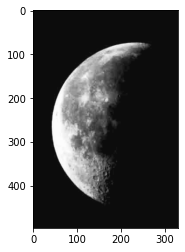

1it [00:48, 48.58s/it]

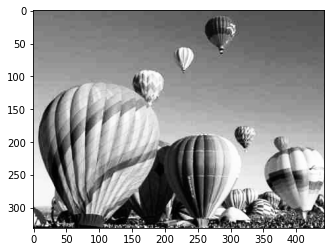

2it [01:27, 43.06s/it]

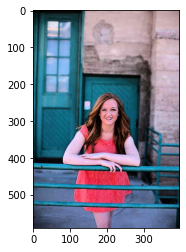

3it [02:41, 57.15s/it]

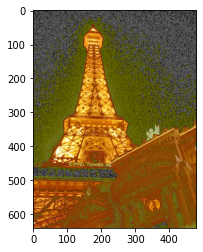

4it [04:11, 70.02s/it]

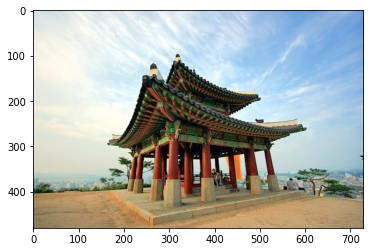

5it [05:46, 78.99s/it]

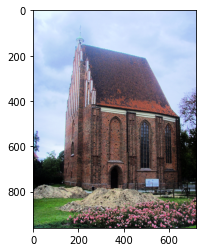

6it [09:16, 123.67s/it]

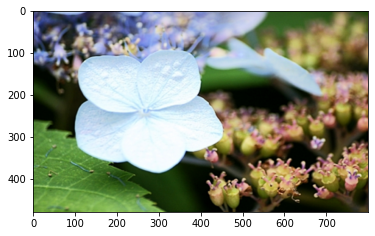

7it [11:19, 97.05s/it] 


In [29]:
### YOUR CODE HERE ###
from tqdm import tqdm
np.seterr(divide='ignore', invalid='ignore')
img_names = os.listdir('testdata/')
for i, img_name in tqdm(enumerate(img_names)):
    img = cv2.imread(os.path.join('testdata/', img_name))
    result = dhe(img)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB) # for showing purpose
    plt.imshow(result)
    plt.show()
### YOUR CODE HERE ###